In [721]:
import pandas as pd
from datetime import datetime, timedelta 

# 1.1 Cargar archivos CSV (separador ; y utf-8 encoding)

In [722]:
path_base="Data\\Extraidos\\"

In [723]:
# --- Función auxiliar para expandir bloques de disponibilidad por hora ---
def expandir_bloques(hora_inicio, hora_fin):
    formato = "%H:%M"
    h_inicio = datetime.strptime(hora_inicio, formato)
    h_fin = datetime.strptime(hora_fin, formato)
    bloques = []
    while h_inicio < h_fin:
        bloques.append(h_inicio.strftime(formato))
        h_inicio += timedelta(hours=1)
    return bloques

In [724]:
# --- Cargar duracion_asignatura.csv ---
df_duracion = pd.read_csv(path_base+"duracion_asignatura.csv",sep=";",encoding="utf-8-sig")
dict_duracion = dict(zip(df_duracion["CodAsignatura"], df_duracion["DuracionHoras"]))
dict_curso_ciclo = dict(zip(df_duracion["CodAsignatura"], df_duracion["Ciclo"]))

In [725]:
# --- Cargar plan_estudios.csv y generar diccionario de prerequisitos ---
df_plan = pd.read_csv(path_base+"plan_estudios.csv",sep=";",encoding="utf-8-sig")
df_con_prereq = df_plan.dropna(subset=["Cod Pre-Requisito"])
dict_prerequisitos = df_con_prereq.groupby("CodAsignatura")["Cod Pre-Requisito"].apply(list).to_dict()

In [726]:
# Asegurar que todos los cursos estén en el diccionario
for cod in df_plan["CodAsignatura"].unique():
    dict_prerequisitos.setdefault(cod, [])

In [727]:
# --- Cargar docentes_minimos.csv y construir estructura por curso ---
df_docentes_min = pd.read_csv(path_base+"docentes_minimos.csv",sep=";",encoding="utf-8-sig")
dict_cursos_secciones = {}

In [728]:
for _, row in df_docentes_min.iterrows():
    cod = row["CodAsignatura"]
    dict_cursos_secciones[cod] = {
        "NomAsignatura": row["NomAsignatura"],
        "NumGrupos": int(row["NumGrupos"]),
        "DuracionHoras": float(row["DuracionHoras"]),
        "Matriculados": int(row["Matriculados"])
    }

In [729]:
dict_cursos_secciones

{'202W0301': {'NomAsignatura': 'ALGORÍTMICA I',
  'NumGrupos': 1,
  'DuracionHoras': 5.0,
  'Matriculados': 10},
 '202W0302': {'NomAsignatura': 'ESTADÍSTICA',
  'NumGrupos': 1,
  'DuracionHoras': 5.0,
  'Matriculados': 5},
 '202W0303': {'NomAsignatura': 'FISICA ELÉCTRONICA',
  'NumGrupos': 1,
  'DuracionHoras': 4.0,
  'Matriculados': 6},
 '202W0304': {'NomAsignatura': 'INGENIERÍA ECONÓMICA',
  'NumGrupos': 1,
  'DuracionHoras': 4.0,
  'Matriculados': 2},
 '202W0305': {'NomAsignatura': 'INTRODUCCIÓN AL DESARROLLO DE SOFTWARE',
  'NumGrupos': 1,
  'DuracionHoras': 4.0,
  'Matriculados': 4},
 '202W0306': {'NomAsignatura': 'MATEMÁTICA BÁSICA',
  'NumGrupos': 1,
  'DuracionHoras': 5.0,
  'Matriculados': 5},
 '202W0307': {'NomAsignatura': 'ORGANIZACIÓN Y ADMINISTRACIÓN',
  'NumGrupos': 1,
  'DuracionHoras': 4.0,
  'Matriculados': 1},
 '202W0401': {'NomAsignatura': 'ALGORÍTMICA II',
  'NumGrupos': 1,
  'DuracionHoras': 5.0,
  'Matriculados': 6},
 '202W0402': {'NomAsignatura': 'CONTABILIDAD PA

In [730]:
# --- Cargar disponibilidad_docente_simulada.csv y expandir bloques ---
df_disp = pd.read_csv(path_base+"disponibilidad_docentes_simulada.csv",sep=",",encoding="utf-8-sig")
df_disp["Día"] = df_disp["Día"].str.capitalize()

In [731]:
df_disp.head()

,CodDocente,CodAsignatura,Día,HoraInicio,HoraFin,DuracionHoras,Ciclo
0,085774,202W0301,Lunes,14:00,19:00,5.0,3
1,0A1609,202W0301,Jueves,17:00,22:00,5.0,3
2,0A9179,202W0301,Lunes,08:00,13:00,5.0,3
3,007056,202W0302,Jueves,08:00,13:00,5.0,3
4,043788,202W0302,Jueves,08:00,13:00,5.0,3


In [732]:
# Eliminar duplicados para quedarte solo con relaciones únicas docente-curso
df_docente_curso = df_disp[["CodDocente", "CodAsignatura"]].drop_duplicates()

# Agrupar por docente si quieres ver todos los cursos que puede dictar
docentes_con_cursos = df_docente_curso.groupby("CodDocente")["CodAsignatura"].apply(list).reset_index()

# Si quieres usarlo como diccionario:
dict_docente_cursos = df_docente_curso.groupby("CodDocente")["CodAsignatura"].apply(set).to_dict()

In [733]:
dict_disponibilidad_expandida = {}
dict_docentes_por_curso = {}

In [734]:
for _, row in df_disp.iterrows():
    docente = row["CodDocente"]
    curso = row["CodAsignatura"]
    dia = row["Día"]
    bloques = expandir_bloques(row["HoraInicio"], row["HoraFin"])

    dict_disponibilidad_expandida.setdefault(docente, {}).setdefault(curso, {}).setdefault(dia, []).extend(bloques)
    dict_docentes_por_curso.setdefault(curso, set()).add(docente)

In [735]:
# Convertir sets a listas
for curso in dict_docentes_por_curso:
    dict_docentes_por_curso[curso] = list(dict_docentes_por_curso[curso])

In [736]:

# ==== CONFIGURACIÓN GENERAL ====

DIAS = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado"]
BLOQUES_HORARIOS = [f"{h:02d}:00" for h in range(8, 22)]  # De 08:00 a 21:00

# Prefijo para identificar docentes contratados externamente
PREFIJO_DOCENTE_CONTRATADO = "DC"

# Pesos según categoría con escala áurea (excepto categoría 6, que es hard constraint)
PESO_CONSTRAINS = {
    "cursos_mismo_ciclo": 1000,                         # 6
    "prereq_vs_ciclos_vecinos": 162,                  # 2
    "docente_min12h": 685,                            # 5 (anteriormente docente_max12h)
    "min_docentes_por_curso": 685,                    # 5
    #"docente_max_horas": 685,                         # 5 (máximo según disponibilidad)
    "prefer_ciclo_1a5_mananatarde": 423,              # 4
    "sabado": 50,                                     # extra por cursos asignados en sábado
    "preferencias_docentes": 261,                     # 3
    "evitar_3_franjas_mismo_dia": 261,                # 3
    "espacios_docente": 261,                          # 3
    "espacios_ciclo": 261,                            # 3
    "cantidad_docentes_contratados": 423,             # 4
    "docente_sin_espacios_largos": 261,               # 3 (alias de espacios_docente)
    "curso_sin_espacios_largos": 261                  # 3 (alias de espacios_ciclo)
    # Categoría 6 (hard constraints) se validan durante generación:
    # - duración exacta del curso
    # - horario permitido
}



In [737]:
import random
import datetime as dt
from datetime import timedelta

contador_docentes_contratados = 0  # Global para generar nuevos códigos únicos


def generar_codigo_docente_contratado():
    global contador_docentes_contratados
    contador_docentes_contratados += 1
    return f"{PREFIJO_DOCENTE_CONTRATADO}{contador_docentes_contratados:05d}"


def generar_individuo():
    individuo = []
    horas_por_docente = defaultdict(float)

    for cod_curso, datos in dict_cursos_secciones.items():
        duracion = int(datos["DuracionHoras"])
        num_grupos = int(datos["NumGrupos"])
        ciclo = dict_curso_ciclo[cod_curso]
        posibles_docentes = dict_docentes_por_curso.get(cod_curso, []).copy()

        for grupo in range(num_grupos):
            asignado = False

            # Ordenar docentes priorizando quienes ya tienen carga menor a 11 horas
            posibles_docentes.sort(key=lambda d: (
                horas_por_docente[d] >= 11,  # False primero
                horas_por_docente[d]         # Menor carga primero
            ))

            for docente in posibles_docentes:
                disponibilidad = dict_disponibilidad_expandida.get(docente, {}).get(cod_curso, {})
                dias = list(disponibilidad.keys())
                random.shuffle(dias)

                for dia in dias:
                    bloques = disponibilidad[dia]
                    bloques_validos = [
                        b for b in bloques
                        if b >= "08:00" and (b < "13:00" or b >= "14:00")
                    ]

                    for i in range(len(bloques_validos) - duracion + 1):
                        subbloque = bloques_validos[i:i + duracion]
                        hora_inicio = subbloque[0]
                        hora_fin = (dt.datetime.strptime(subbloque[-1], "%H:%M") + timedelta(hours=1)).strftime("%H:%M")

                        individuo.append({
                            "CodAsignatura": cod_curso,
                            "NomAsignatura": datos["NomAsignatura"],
                            "CodDocente": docente,
                            "Dia": dia,
                            "HoraInicio": hora_inicio,
                            "HoraFin": hora_fin,
                            "DuracionHoras": duracion,
                            "Ciclo": ciclo
                        })
                        horas_por_docente[docente] += duracion
                        asignado = True
                        break
                    if asignado:
                        break
                if asignado:
                    break

            # Si no se pudo asignar con docentes actuales, contratar uno nuevo
            if not asignado:
                nuevo_docente = generar_codigo_docente_contratado()
                dia_random = random.choice(DIAS)
                hora_index = random.randint(0, len(BLOQUES_HORARIOS) - duracion)
                subbloque = BLOQUES_HORARIOS[hora_index:hora_index + duracion]
                hora_inicio = subbloque[0]
                hora_fin = (dt.datetime.strptime(subbloque[-1], "%H:%M") + timedelta(hours=1)).strftime("%H:%M")

                individuo.append({
                    "CodAsignatura": cod_curso,
                    "NomAsignatura": datos["NomAsignatura"],
                    "CodDocente": nuevo_docente,
                    "Dia": dia_random,
                    "HoraInicio": hora_inicio,
                    "HoraFin": hora_fin,
                    "DuracionHoras": duracion,
                    "Ciclo": ciclo
                })

    return individuo



In [738]:
from collections import defaultdict


def calcular_fitness(individuo):
    penalizaciones = defaultdict(int)
    sesiones_por_docente = defaultdict(lambda: defaultdict(list))  # docente -> dia -> sesiones
    sesiones_por_ciclo = defaultdict(lambda: defaultdict(list))    # ciclo -> dia -> sesiones
    sesiones_por_curso = defaultdict(list)
    secciones_asignadas = set()
    docentes_contratados = set()
    penalizaciones_por_docente_curso = defaultdict(int)
    horas_acumuladas_docente = defaultdict(float)

    # === Validación docente puede dictar curso
    for sesion in individuo:
        docente = sesion["CodDocente"]
        curso = sesion["CodAsignatura"]
        dia = sesion["Dia"]
        hora_ini = sesion["HoraInicio"]
        hora_fin = sesion["HoraFin"]
        duracion = sesion["DuracionHoras"]
        ciclo = sesion["Ciclo"]

        # Penalizar si el docente no está autorizado a dictar el curso
        if docente in dict_docente_cursos:
            if curso not in dict_docente_cursos[docente]:
                penalizaciones["docente_no_puede_dictar"]=0 #+= 10000
        else:
            # Si el docente no está en el diccionario, asumir que no puede dictar
            penalizaciones["docenteno_puede_dictar"]=0 #+= 10_000

        # === Hard constraint 1: horario válido
        if not ("08:00" <= hora_ini < "13:00" or "14:00" <= hora_ini < "22:00"):
            penalizaciones["horario_fuera_rango"] += 1000

        # === Hard constraint 2: duración correcta
        if dict_duracion.get(curso, duracion) != duracion:
            penalizaciones["duracion_incorrecta"] += 1000

        # === Agrupación para validaciones posteriores
        sesiones_por_docente[docente][dia].append(sesion)
        sesiones_por_ciclo[ciclo][dia].append(sesion)
        sesiones_por_curso[curso].append(docente)
        secciones_asignadas.add((curso, docente))

        if docente.startswith(PREFIJO_DOCENTE_CONTRATADO):
            docentes_contratados.add(docente)

        horas_acumuladas_docente[docente] += duracion

        # Penalización por sábado
        if dia == "Sábado":
            penalizaciones["sabado"] += PESO_CONSTRAINS["sabado"]

        # Penalización por preferencia horaria según ciclo
        h_ini_int = int(hora_ini[:2])
        if ciclo <= 5 and not (8 <= h_ini_int < 13 or 14 <= h_ini_int < 18):
            penalizaciones["prefer_ciclo_1a5_mananatarde"] += PESO_CONSTRAINS["prefer_ciclo_1a5_mananatarde"]
        if ciclo >= 6 and not (18 <= h_ini_int < 22):
            penalizaciones["prefer_ciclo_1a5_mananatarde"] += PESO_CONSTRAINS["prefer_ciclo_1a5_mananatarde"]

    # === Restricciones por docente
    for docente, dias in sesiones_por_docente.items():
        total_horas_docente = horas_acumuladas_docente[docente]

        for dia, sesiones in dias.items():
            sesiones.sort(key=lambda x: x["HoraInicio"])
            franjas = set()
            horas_dia = []

            for s in sesiones:
                h_ini = int(s["HoraInicio"][:2])
                h_fin = int(s["HoraFin"][:2])
                horas_dia.extend(range(h_ini, h_fin))

                if h_ini < 13:
                    franjas.add("mañana")
                elif h_ini < 18:
                    franjas.add("tarde")
                else:
                    franjas.add("noche")

            # Huecos mayores a 3h
            if len(horas_dia) > 1:
                gaps = [horas_dia[i+1] - horas_dia[i] for i in range(len(horas_dia)-1)]
                if any(g > 3 for g in gaps):
                    penalizaciones["espacios_docente"] += PESO_CONSTRAINS["espacios_docente"]

            # Más de 2 franjas horarias en un solo día
            if len(franjas) > 2:
                penalizaciones["evitar_3_franjas_mismo_dia"] += PESO_CONSTRAINS["evitar_3_franjas_mismo_dia"]

        # Penalización proporcional si está fuera del rango recomendado
        if total_horas_docente < 11:
            penalizaciones["docente_menos_11"]=0 #+= (12 - total_horas_docente) * int(PESO_CONSTRAINS["docente_min12h"] / 2)
        elif total_horas_docente > 13:
            penalizaciones["docente_mayor_13"]=0 #+= (total_horas_docente - 14) * int(PESO_CONSTRAINS["docente_min12h"] / 2)

    # === Restricciones por ciclo
    for ciclo, dias in sesiones_por_ciclo.items():
        sesiones_ciclo = []
        dias_usados = set()
        bloques_horarios = []

        for dia, sesiones in dias.items():
            sesiones_ciclo.extend(sesiones)
            dias_usados.add(dia)
            for s in sesiones:
                h_ini = int(s["HoraInicio"][:2])
                h_fin = int(s["HoraFin"][:2])
                bloques_horarios.append((h_ini, h_fin))

            sesiones.sort(key=lambda x: x["HoraInicio"])
            franjas = set()
            horas_dia = []

            for s in sesiones:
                h_ini = int(s["HoraInicio"][:2])
                h_fin = int(s["HoraFin"][:2])
                horas_dia.extend(range(h_ini, h_fin))
                if h_ini < 13:
                    franjas.add("mañana")
                elif h_ini < 18:
                    franjas.add("tarde")
                else:
                    franjas.add("noche")

            # Evitar más de 2 franjas en un día
            if len(franjas) > 2:
                penalizaciones["evitar_3_franjas_mismo_dia"] += PESO_CONSTRAINS["evitar_3_franjas_mismo_dia"]

            # Huecos > 3h entre cursos del mismo ciclo
            if len(horas_dia) > 1:
                gaps = [horas_dia[i+1] - horas_dia[i] for i in range(len(horas_dia)-1)]
                if any(g > 3 for g in gaps):
                    penalizaciones["espacios_ciclo"] += PESO_CONSTRAINS["espacios_ciclo"]

        penalizo_por_dias = False
        if len(dias_usados) > 2:
            penalizaciones["cursos_mismo_ciclo"] += (len(dias_usados) - 2) * PESO_CONSTRAINS["cursos_mismo_ciclo"]
            penalizo_por_dias = True

        if not penalizo_por_dias:
            bloques_horarios.sort()
            for i in range(1, len(bloques_horarios)):
                prev_fin = bloques_horarios[i-1][1]
                curr_ini = bloques_horarios[i][0]
                if curr_ini - prev_fin >= 4:
                    penalizaciones["cursos_mismo_ciclo"] += PESO_CONSTRAINS["cursos_mismo_ciclo"]

    # Penalización por docentes contratados
    penalizaciones["cantidad_docentes_contratados"] += len(docentes_contratados) * PESO_CONSTRAINS["cantidad_docentes_contratados"]

    # Penalizar si algún curso no fue asignado
    for cod in dict_cursos_secciones:
        if cod not in sesiones_por_curso:
            penalizaciones["min_docentes_por_curso"] += PESO_CONSTRAINS["min_docentes_por_curso"]

    # Penalización individual por docente-curso para posible fijado posterior
    for curso, docentes in sesiones_por_curso.items():
        for docente in docentes:
            key = (curso, docente)
            penalizaciones_por_docente_curso[key] = sum(
                p for k, p in penalizaciones.items()
                if k not in ["cantidad_docentes_contratados", "min_docentes_por_curso"]
            )

    fitness_total = -sum(penalizaciones.values())
    return fitness_total, penalizaciones, penalizaciones_por_docente_curso


In [739]:
def cruzar_dirigido_por_penalizacion(ind1, ind2, calcular_fitness):
    _, penalizaciones_1,_ = calcular_fitness(ind1)
    #fitness, penalizaciones, penalizaciones_por_docente_curso
    # Crear un conjunto con claves únicas por curso y docente
    claves_sesiones = [(s["CodAsignatura"], s["CodDocente"], s["Dia"], s["HoraInicio"]) for s in ind1]

    # Asignar penalización total a cada sesión del primer individuo
    penalizaciones_por_sesion = {}
    for s in ind1:
        key = (s["CodAsignatura"], s["CodDocente"], s["Dia"], s["HoraInicio"])
        penalizaciones_por_sesion[key] = 0

    for key in penalizaciones_1:
        for s in ind1:
            k = (s["CodAsignatura"], s["CodDocente"], s["Dia"], s["HoraInicio"])
            penalizaciones_por_sesion[k] += penalizaciones_1[key]

    # Ordenar sesiones por penalización descendente
    sesiones_ordenadas = sorted(ind1, key=lambda s: penalizaciones_por_sesion[
        (s["CodAsignatura"], s["CodDocente"], s["Dia"], s["HoraInicio"])
    ], reverse=True)

    # Hacer una copia del individuo base
    hijo = ind1.copy()

    # Reemplazar las sesiones más penalizadas con las correspondientes de ind2 (si existen)
    for sesion in sesiones_ordenadas:
        reemplazo = next(
            (s for s in ind2 if s["CodAsignatura"] == sesion["CodAsignatura"] and s["Dia"] == sesion["Dia"]),
            None
        )
        if reemplazo:
            hijo.remove(sesion)
            hijo.append(reemplazo)

    return hijo


In [740]:
def mutar_individuo_genetico(individuo, calcular_fitness):
    nuevo_individuo = generar_individuo()
    hijo_mutado = cruzar_dirigido_por_penalizacion(individuo, nuevo_individuo, calcular_fitness)
    return hijo_mutado

In [741]:
codigos_docentes_existentes = set(df_disp["CodDocente"].unique())

In [742]:
def run_algoritmo_genetico(
    generar_individuo,
    calcular_fitness,
    generaciones=50,
    poblacion_size=20,
    prob_mutacion=0.2
):
    historial = []

    # 1. Crear población inicial válida
    poblacion = []
    while len(poblacion) < poblacion_size:
        individuo = generar_individuo()
        if individuo:
            poblacion.append(individuo)

    for gen in range(generaciones):
        evaluaciones = []
        for ind in poblacion:
            fitness, penalizaciones, penalizaciones_por_docente_curso = calcular_fitness(ind)
            evaluaciones.append((fitness, ind, penalizaciones))

        # Ordenar por fitness (menor es mejor)
        evaluaciones.sort(key=lambda x: x[0])
        historial.append(evaluaciones[0])  # Guardar el mejor de la generación

        # Selección: top 50%
        seleccionados = [e[1] for e in evaluaciones[:poblacion_size // 2]]

        nueva_poblacion = seleccionados[:]

        while len(nueva_poblacion) < poblacion_size:
            padre1, padre2 = random.sample(seleccionados, 2)
            hijo = cruzar_dirigido_por_penalizacion(padre1, padre2, calcular_fitness)

            if random.random() < prob_mutacion:
                hijo = mutar_individuo_genetico(hijo, calcular_fitness)

            nueva_poblacion.append(hijo)

        poblacion = nueva_poblacion

    # Retornar historial y el mejor individuo final
    mejor_fitness, mejor_individuo, penalizaciones = min(
        [(calcular_fitness(ind)[0], ind, calcular_fitness(ind)[1]) for ind in poblacion],
        key=lambda x: x[0]
    )
    historial.append((mejor_fitness, mejor_individuo, penalizaciones))
    return historial, mejor_individuo


In [743]:
import matplotlib.pyplot as plt

def graficar_penalizaciones_generaciones(historial):
    """
    Recibe una lista de tuplas (fitness, individuo, penalizaciones) por generación.
    Puede manejar tuplas con más elementos ignorando los extras.
    """
    penalizaciones_por_tipo = {}

    for gen_index, entrada in enumerate(historial):
        if len(entrada) < 3:
            continue  # saltar si no hay penalizaciones

        penalizaciones = entrada[2]  # asume que están en la tercera posición

        for tipo, valor in penalizaciones.items():
            penalizaciones_por_tipo.setdefault(tipo, []).append((gen_index, valor))

    plt.figure(figsize=(12, 6))
    for tipo, puntos in penalizaciones_por_tipo.items():
        generaciones, valores = zip(*puntos)
        plt.plot(generaciones, valores, label=tipo)

    plt.title("Penalizaciones por generación (Algoritmo Genético)")
    plt.xlabel("Generación")
    plt.ylabel("Penalización acumulada")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()


In [744]:
from copy import deepcopy
import random
import datetime as dt

def generar_vecino(individuo, num_vecinos=5):
    vecinos = []

    for _ in range(num_vecinos):
        vecino = deepcopy(individuo)

        # Evaluar fitness actual
        _, penalizaciones,_ = calcular_fitness(vecino)

        # Detectar penalización más fuerte
        penal_mayor = max(penalizaciones.items(), key=lambda x: x[1])[0] if penalizaciones else None

        # Escoger una sesión al azar
        idx = random.randint(0, len(vecino) - 1)
        sesion = vecino[idx]
        docente = sesion["CodDocente"]
        curso = sesion["CodAsignatura"]
        ciclo = sesion["Ciclo"]
        duracion = sesion["DuracionHoras"]
        dia_actual = sesion["Dia"]

        if penal_mayor == "docente_max12h":
            horas_docente = sum(s["DuracionHoras"] for s in vecino if s["CodDocente"] == docente)
            if horas_docente > 14:
                # Contratar nuevo docente
                nuevo_docente = f"{PREFIJO_DOCENTE_CONTRATADO}{random.randint(0, 99999):05d}"
                for dia in DIAS:
                    hora_ini_int = random.choice(list(range(8, 22 - int(duracion))))
                    hora_ini = f"{hora_ini_int:02d}:00"
                    hora_fin = f"{hora_ini_int + int(duracion):02d}:00"
                    if hora_ini < "13:00" or hora_ini >= "14:00":
                        sesion["CodDocente"] = nuevo_docente
                        sesion["Dia"] = dia
                        sesion["HoraInicio"] = hora_ini
                        sesion["HoraFin"] = hora_fin
                        break

        elif penal_mayor == "cursos_mismo_ciclo":
            dias_usados = set(s["Dia"] for s in vecino if s["Ciclo"] == ciclo and s != sesion)
            dias_disponibles = [d for d in DIAS if d not in dias_usados]

            random.shuffle(dias_disponibles)
            disponibilidad = dict_disponibilidad_expandida.get(docente, {}).get(curso, {})

            for nuevo_dia in dias_disponibles:
                bloques = disponibilidad.get(nuevo_dia, [])
                bloques_validos = [b for b in bloques if b >= "08:00" and (b < "13:00" or b >= "14:00")]

                for i in range(len(bloques_validos) - duracion + 1):
                    subbloque = bloques_validos[i:i + duracion]
                    if len(subbloque) != duracion:
                        continue
                    hora_ini = subbloque[0]
                    hora_fin = (dt.datetime.strptime(subbloque[-1], "%H:%M") + dt.timedelta(hours=1)).strftime("%H:%M")
                    sesion["Dia"] = nuevo_dia
                    sesion["HoraInicio"] = hora_ini
                    sesion["HoraFin"] = hora_fin
                    break
                else:
                    continue
                break

        vecino[idx] = sesion
        vecinos.append(vecino)

    return vecinos



In [745]:
def contratar_docente_por_penalizacion(individuo):
    nuevo_individuo = deepcopy(individuo)
    _, penalizaciones, penalizaciones_por_docente_curso = calcular_fitness(nuevo_individuo)

    # Identificar la penalización dominante
    penalizacion_dominante = max(penalizaciones, key=penalizaciones.get)

    if penalizacion_dominante != "docente_max12h":
        return None  # Solo actuamos si la penalización principal es por exceso o déficit de horas

    # Contar horas por docente
    horas_por_docente = defaultdict(float)
    for sesion in nuevo_individuo:
        horas_por_docente[sesion["CodDocente"]] += sesion["DuracionHoras"]

    # Buscar el docente más penalizado por carga horaria
    docente_objetivo = max(horas_por_docente.items(), key=lambda x: abs(x[1] - 12))[0]

    # Buscar sesiones de ese docente
    sesiones_docente = [i for i, s in enumerate(nuevo_individuo) if s["CodDocente"] == docente_objetivo]
    if not sesiones_docente:
        return None

    idx_cambiar = random.choice(sesiones_docente)
    sesion = nuevo_individuo[idx_cambiar]

    curso = sesion["CodAsignatura"]
    ciclo = sesion["Ciclo"]
    duracion = sesion["DuracionHoras"]

    # Generar código de docente contratado
    nuevo_codigo = f"{PREFIJO_DOCENTE_CONTRATADO}{random.randint(0, 99999):05d}"

    # Asignar horario aleatorio válido
    for dia in DIAS:
        for h in range(8, 22 - int(duracion) + 1):
            hora_ini = f"{h:02d}:00"
            hora_fin = f"{h + int(duracion):02d}:00"
            if hora_ini < "13:00" or hora_ini >= "14:00":
                nueva_sesion = {
                    "CodAsignatura": curso,
                    "NomAsignatura": sesion["NomAsignatura"],
                    "CodDocente": nuevo_codigo,
                    "Dia": dia,
                    "HoraInicio": hora_ini,
                    "HoraFin": hora_fin,
                    "DuracionHoras": duracion,
                    "Ciclo": ciclo
                }
                nuevo_individuo[idx_cambiar] = nueva_sesion
                return nuevo_individuo

    return None


In [746]:
import random
from copy import deepcopy

def mutacion_aleatoria(individuo):
    if not individuo:
        return None

    nuevo = deepcopy(individuo)
    sesion_idx = random.randint(0, len(nuevo) - 1)
    sesion = nuevo[sesion_idx].copy()
    cod_curso = sesion["CodAsignatura"]
    dia = sesion["Dia"]
    duracion = sesion["DuracionHoras"]

    # Obtener posibles docentes que pueden dictar ese curso
    posibles_docentes = list(dict_docente_cursos.get(cod_curso, []))
    if not posibles_docentes:
        return None

    # Opción: priorizar docentes que ya están en el individuo
    docentes_ya_usados = set(s["CodDocente"] for s in nuevo)
    candidatos_prioritarios = [d for d in posibles_docentes if d in docentes_ya_usados]
    candidatos = candidatos_prioritarios if candidatos_prioritarios else posibles_docentes

    nuevo_docente = random.choice(candidatos)
    sesion["CodDocente"] = nuevo_docente

    # Reemplazar en el individuo
    nuevo[sesion_idx] = sesion
    return nuevo


In [747]:
from copy import deepcopy

def ejecutar_busqueda_tabu(
    solucion_inicial,
    calcular_fitness,
    max_iteraciones=50,
    tamaño_tabu=10,
    generar_vecinos=None,
    contratar_docente_por_penalizacion=None
):
    mejor_solucion = solucion_inicial
    _, penalizaciones, _ = calcular_fitness(mejor_solucion)
    mejor_fitness = sum(PESO_CONSTRAINS.get(tipo, 1) * valor for tipo, valor in penalizaciones.items())

    historial = [(0, mejor_fitness)]
    memoria_tabu = []
    penalizaciones_historial = []

    for iteracion in range(1, max_iteraciones + 1):
        vecinos = generar_vecinos(mejor_solucion)

        mejor_vecino = None
        mejor_vecino_fitness = float('inf')
        mejor_vecino_penalizaciones = {}

        for vecino in vecinos:
            if vecino in memoria_tabu:
                continue

            _, penalizaciones, _ = calcular_fitness(vecino)
            fitness_ponderado = sum(PESO_CONSTRAINS.get(tipo, 1) * valor for tipo, valor in penalizaciones.items())

            if fitness_ponderado < mejor_vecino_fitness:
                mejor_vecino = vecino
                mejor_vecino_fitness = fitness_ponderado
                mejor_vecino_penalizaciones = penalizaciones

        if mejor_vecino is None:
            # Intentar contratar docente
            vecino_modificado = contratar_docente_por_penalizacion(mejor_solucion)

            if vecino_modificado is None:
                # Intentar mutación aleatoria como último recurso
                vecino_modificado = mutacion_aleatoria(mejor_solucion)
                if vecino_modificado is None:
                    print("No se pudo generar un nuevo individuo en esta iteración.")
                    continue

            _, penalizaciones, _ = calcular_fitness(vecino_modificado)
            mejor_vecino = vecino_modificado
            mejor_vecino_fitness = sum(PESO_CONSTRAINS.get(tipo, 1) * valor for tipo, valor in penalizaciones.items())
            mejor_vecino_penalizaciones = penalizaciones

        # Actualizar lista tabú
        memoria_tabu.append(mejor_vecino)
        if len(memoria_tabu) > tamaño_tabu:
            memoria_tabu.pop(0)

        # Reemplazar si mejora
        if mejor_vecino_fitness < mejor_fitness:
            mejor_solucion = mejor_vecino
            mejor_fitness = mejor_vecino_fitness

        historial.append((iteracion, mejor_fitness))
        penalizaciones_historial.append(mejor_vecino_penalizaciones)

    return historial, mejor_solucion, penalizaciones_historial


In [748]:
import matplotlib.pyplot as plt

def graficar_penalizaciones_tabu(historial_penalizaciones_tabu, top_k=5):
    """
    Grafica la evolución de las penalizaciones más comunes a lo largo de la búsqueda Tabú.

    Args:
        historial_penalizaciones_tabu: lista de diccionarios de penalizaciones por iteración.
        top_k: cuántas penalizaciones más frecuentes mostrar.
    """
    if not historial_penalizaciones_tabu:
        print("No hay datos para graficar.")
        return

    # Obtener todas las claves posibles de penalización
    todas_las_claves = set()
    for p in historial_penalizaciones_tabu:
        todas_las_claves.update(p.keys())

    # Sumar total de cada tipo de penalización para ordenarlas por impacto total
    totales = {k: sum(p.get(k, 0) for p in historial_penalizaciones_tabu) for k in todas_las_claves}
    claves_top = sorted(totales, key=totales.get, reverse=True)[:top_k]

    # Crear curvas por clave
    for clave in claves_top:
        valores = [p.get(clave, 0) for p in historial_penalizaciones_tabu]
        plt.plot(valores, label=clave)

    plt.xlabel("Iteraciones")
    plt.ylabel("Penalización")
    plt.title(f"Penalizaciones más relevantes en Tabú (Top {top_k})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [749]:
# === BLOQUE DE EJECUCIÓN PRINCIPAL ===

# 1. Ejecutar algoritmo genético
historial_genetico, mejor_individuo_genetico = run_algoritmo_genetico(
    generar_individuo,
    calcular_fitness,
    generaciones=100,
    poblacion_size=1000,
    prob_mutacion=0.2
)


In [750]:
historial_genetico

[(-49738,
  [{'CodAsignatura': '202W0301',
    'NomAsignatura': 'ALGORÍTMICA I',
    'CodDocente': 'Z000000',
    'Dia': 'Viernes',
    'HoraInicio': '15:00',
    'HoraFin': '20:00',
    'DuracionHoras': 5,
    'Ciclo': 3},
   {'CodAsignatura': '202W0302',
    'NomAsignatura': 'ESTADÍSTICA',
    'CodDocente': '007056',
    'Dia': 'Jueves',
    'HoraInicio': '08:00',
    'HoraFin': '13:00',
    'DuracionHoras': 5,
    'Ciclo': 3},
   {'CodAsignatura': '202W0303',
    'NomAsignatura': 'FISICA ELÉCTRONICA',
    'CodDocente': '0A06292',
    'Dia': 'Martes',
    'HoraInicio': '08:00',
    'HoraFin': '12:00',
    'DuracionHoras': 4,
    'Ciclo': 3},
   {'CodAsignatura': '202W0304',
    'NomAsignatura': 'INGENIERÍA ECONÓMICA',
    'CodDocente': '08490635',
    'Dia': 'Viernes',
    'HoraInicio': '08:00',
    'HoraFin': '12:00',
    'DuracionHoras': 4,
    'Ciclo': 3},
   {'CodAsignatura': '202W0305',
    'NomAsignatura': 'INTRODUCCIÓN AL DESARROLLO DE SOFTWARE',
    'CodDocente': '09571E',
  

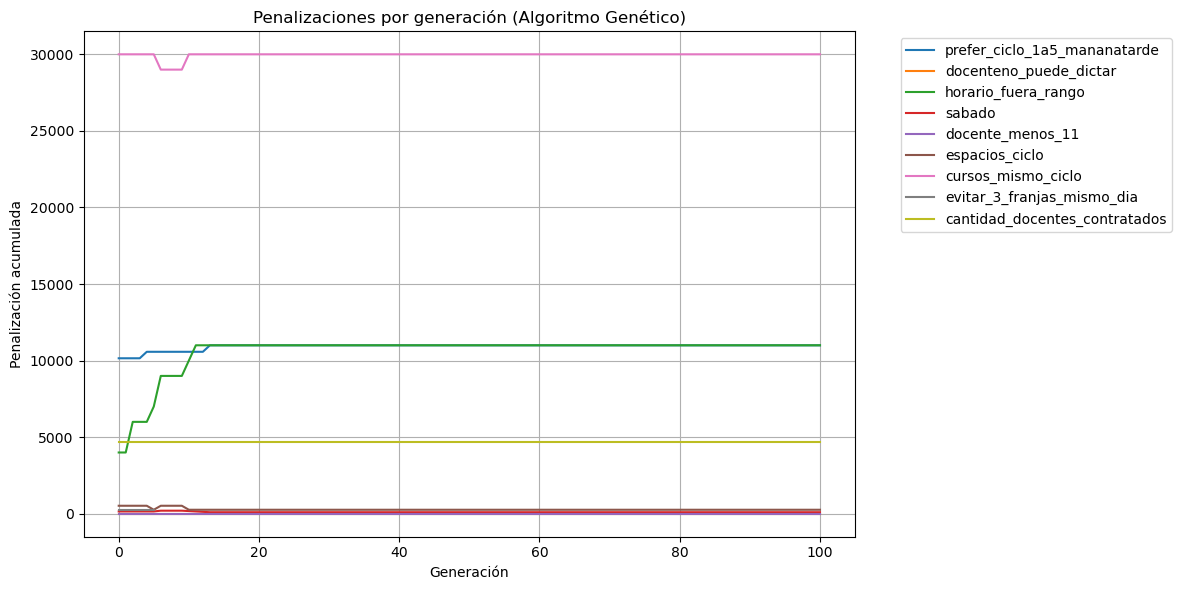

In [751]:
# 2. Graficar evolución genética
graficar_penalizaciones_generaciones(historial_genetico)

In [752]:
# 3. Ejecutar búsqueda tabú usando el mejor individuo del genético
historial_tabu, mejor_individuo_tabu, historial_penalizaciones_tabu = ejecutar_busqueda_tabu(
    mejor_individuo_genetico,
    calcular_fitness,
    max_iteraciones=100,
    generar_vecinos=generar_vecino,
    contratar_docente_por_penalizacion=contratar_docente_por_penalizacion
)


No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo individuo en esta iteración.
No se pudo generar un nuevo ind

In [753]:
historial_penalizaciones_tabu

[defaultdict(int,
             {'docenteno_puede_dictar': 0,
              'horario_fuera_rango': 11000,
              'prefer_ciclo_1a5_mananatarde': 10998,
              'sabado': 100,
              'docente_menos_11': 0,
              'cursos_mismo_ciclo': 30000,
              'espacios_ciclo': 261,
              'cantidad_docentes_contratados': 4653})]

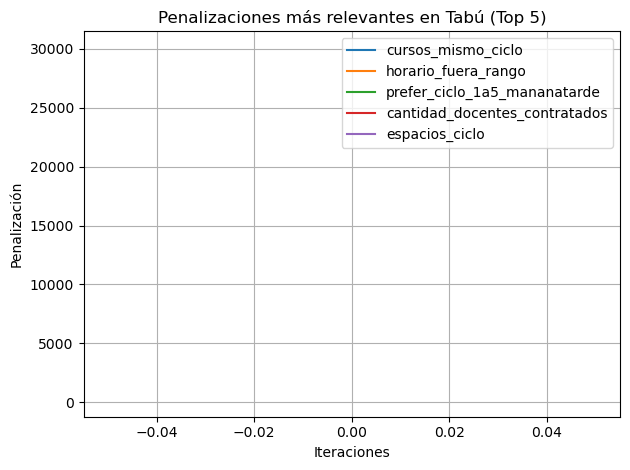

In [754]:
# 4. Graficar evolución de búsqueda tabú
graficar_penalizaciones_tabu(historial_penalizaciones_tabu)

In [755]:
# 5. Guardar resultado final
mejor_horario = mejor_individuo_tabu


In [756]:
import pandas as pd
from collections import defaultdict

def exportar_horario_csv(horario, ruta_salida="output_horario_final.csv"):
    df = pd.DataFrame(horario)

    # === Asignar número de sección ===
    contador_secciones = defaultdict(int)
    asignaciones_seccion = {}

    secciones = []
    for _, row in df.iterrows():
        clave = row["CodAsignatura"]
        docente = row["CodDocente"]
        key = (clave, docente)
        if key not in asignaciones_seccion:
            contador_secciones[clave] += 1
            asignaciones_seccion[key] = contador_secciones[clave]
        secciones.append(asignaciones_seccion[key])

    df["Seccion"] = secciones

    # === Asignar número de estudiantes por sección ===
    estudiantes_por_curso = {}
    for cod, datos in dict_cursos_secciones.items():
        estudiantes_por_curso[cod] = datos["Matriculados"]

    estudiantes_asignados = []
    conteo_secciones = df.groupby("CodAsignatura")["Seccion"].nunique().to_dict()

    for _, row in df.iterrows():
        cod = row["CodAsignatura"]
        total_estudiantes = estudiantes_por_curso.get(cod, 0)
        num_secciones = conteo_secciones.get(cod, 1)
        asignados = total_estudiantes // num_secciones
        estudiantes_asignados.append(asignados)

    df["EstudiantesAsignados"] = estudiantes_asignados

    # === Exportar ===
    columnas_finales = [
        "CodDocente", "CodAsignatura", "Dia", "HoraInicio", "HoraFin",
        "DuracionHoras", "Ciclo", "Seccion", "EstudiantesAsignados"
    ]
    df[columnas_finales].to_csv(ruta_salida, sep=";",encoding="utf-8-sig",index=False)
    print(f"HORARIO EXPORTADO A: {ruta_salida}")

# Llamada
exportar_horario_csv(mejor_horario)


HORARIO EXPORTADO A: output_horario_final.csv
